In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/StockGuide

/content/drive/MyDrive/Colab Notebooks/StockGuide


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [99]:
data = pd.read_csv('./data/삼성전자.csv', parse_dates=['날짜'], index_col='날짜')
data.sort_index(inplace=True)
data.head()

,종가
날짜,
2019-01-02,38750
2019-01-03,37600
2019-01-04,37450
2019-01-07,38750
2019-01-08,38100


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text

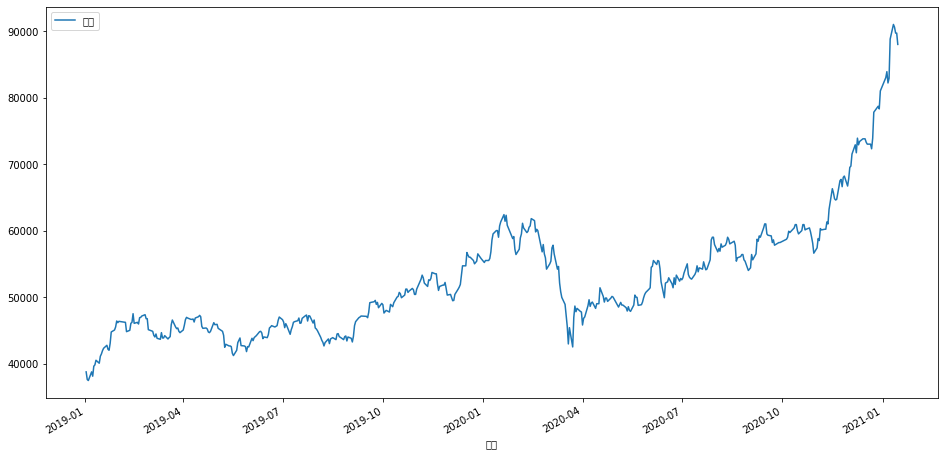

In [100]:
data.plot(figsize=(16,8))

In [101]:
time_step = 26
feature = 1

scaler = MinMaxScaler()
data['종가'] = scaler.fit_transform(data)

data['y_t+1'] = data['종가'].shift(-1)
for t in range(time_step-1, -1, -1):
    data['x_t-'+str(t)] = data['종가'].shift(t)
data.dropna(how='any', inplace=True)
data.head()

,종가,y_t+1,x_t-25,x_t-24,x_t-23,x_t-22,x_t-21,x_t-20,x_t-19,x_t-18,x_t-17,x_t-16,x_t-15,x_t-14,x_t-13,x_t-12,x_t-11,x_t-10,x_t-9,x_t-8,x_t-7,x_t-6,x_t-5,x_t-4,x_t-3,x_t-2,x_t-1,x_t-0
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-11,0.140990,0.160598,0.024276,0.002801,0.000000,0.024276,0.012138,0.040149,0.043884,0.056956,0.048553,0.068161,0.074697,0.084034,0.090570,0.098973,0.087768,0.084967,0.104575,0.136321,0.141923,0.150327,0.167134,0.162465,0.166200,0.163399,0.137255,0.140990
2019-02-12,0.160598,0.163399,0.002801,0.000000,0.024276,0.012138,0.040149,0.043884,0.056956,0.048553,0.068161,0.074697,0.084034,0.090570,0.098973,0.087768,0.084967,0.104575,0.136321,0.141923,0.150327,0.167134,0.162465,0.166200,0.163399,0.137255,0.140990,0.160598
2019-02-13,0.163399,0.187675,0.000000,0.024276,0.012138,0.040149,0.043884,0.056956,0.048553,0.068161,0.074697,0.084034,0.090570,0.098973,0.087768,0.084967,0.104575,0.136321,0.141923,0.150327,0.167134,0.162465,0.166200,0.163399,0.137255,0.140990,0.160598,0.163399
2019-02-14,0.187675,0.160598,0.024276,0.012138,0.040149,0.043884,0.056956,0.048553,0.068161,0.074697,0.084034,0.090570,0.098973,0.087768,0.084967,0.104575,0.136321,0.141923,0.150327,0.167134,0.162465,0.166200,0.163399,0.137255,0.140990,0.160598,0.163399,0.187675
2019-02-15,0.160598,0.163399,0.012138,0.040149,0.043884,0.056956,0.048553,0.068161,0.074697,0.084034,0.090570,0.098973,0.087768,0.084967,0.104575,0.136321,0.141923,0.150327,0.167134,0.162465,0.166200,0.163399,0.137255,0.140990,0.160598,0.163399,0.187675,0.160598


In [102]:
val_start = '2020-10-01'
test_start = '2020-12-01'

train = data[data.index <= val_start]
val = data[(data.index > val_start) & (data.index <= test_start)]
test = data[data.index > test_start]

X_train = train.iloc[:,2:].values
y_train = train.iloc[:,1].values
X_val = val.iloc[:,2:].values
y_val = val.iloc[:,1].values
X_test = test.iloc[:,2:].values
y_test = test.iloc[:,1].values

X_train = X_train.reshape(X_train.shape[0], time_step, feature)
X_val = X_val.reshape(X_val.shape[0], time_step, feature)
X_test = X_test.reshape(X_test.shape[0], time_step, feature)

X_train.shape, X_val.shape, X_test.shape

((408, 26, 1), (41, 26, 1), (29, 26, 1))

# 1. RNN

In [125]:
model1 = Sequential()
model1.add(SimpleRNN(32, input_shape=(time_step, feature)))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='mse', optimizer='adam')
model1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [126]:
model1.fit(X_train, y_train,
           epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
13/13 [==============================] - 1s 24ms/step - loss: 0.0392 - val_loss: 0.0226
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0091
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0025
Epoc

In [127]:
model1.evaluate(X_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0035


0.0035268007777631283

In [128]:
result = pd.DataFrame(scaler.inverse_transform(test[['y_t+1']]), columns=['y_t+1'])
result['p_rnn'] = scaler.inverse_transform(model1.predict(X_test))
result.head()

,y_t+1,p_rnn
0,69700.0,68587.953125
1,71500.0,69581.164062
2,72900.0,70659.679688
3,71700.0,71847.382812
4,73900.0,71328.000000


# 2. LSTM

In [129]:
model2 = Sequential()
model2.add(LSTM(32, input_shape=(time_step, feature)))
model2.add(Dense(1, activation='linear'))

model2.compile(loss='mse', optimizer='adam')
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [130]:
model2.fit(X_train, y_train,
           epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
13/13 [==============================] - 2s 51ms/step - loss: 0.0421 - val_loss: 0.0112
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 3/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0145
Epoch 4/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0052
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 6/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 7/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 9/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 10/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0021

In [131]:
model2.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0025


0.0025269347243010998

In [132]:
result['p_lstm'] = scaler.inverse_transform(model2.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm
0,69700.0,68587.953125,68084.742188
1,71500.0,69581.164062,68756.320312
2,72900.0,70659.679688,70002.835938
3,71700.0,71847.382812,71426.000000
4,73900.0,71328.000000,71628.914062


# 3.Bi-LSTM

In [133]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(32), input_shape=(time_step, feature)))
model3.add(Dense(1, activation='linear'))

model3.compile(loss='mse', optimizer='adam')
model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 64)                8704      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [134]:
model3.fit(X_train, y_train,
           epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
13/13 [==============================] - 4s 87ms/step - loss: 0.0460 - val_loss: 0.0035
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0140
Epoch 3/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0032 - val_loss: 0.0150
Epoch 4/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0077
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 7/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 8/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 10/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0019

In [135]:
model3.evaluate(X_test, y_test)

1/1 [==============================] - 0s 25ms/step - loss: 0.0081


0.008131036534905434

In [136]:
result['p_bi-lstm'] = scaler.inverse_transform(model3.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm,p_bi-lstm
0,69700.0,68587.953125,68084.742188,66863.210938
1,71500.0,69581.164062,68756.320312,67488.578125
2,72900.0,70659.679688,70002.835938,68641.875000
3,71700.0,71847.382812,71426.000000,69895.070312
4,73900.0,71328.000000,71628.914062,69922.890625


# 4.LSTM + Attention

In [137]:
input = Input(shape=(time_step, feature))
lstm, h_state, c_state = LSTM(32, return_sequences=True, return_state=True)(input)
attention = Attention()([h_state, lstm])
context_vector = tf.reduce_sum(attention, axis=1)
output = Dense(1, activation='linear')(context_vector)
model4 = Model(inputs=input, outputs=output)

model4.compile(loss='mse', optimizer='adam')
model4.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  [(None, 26, 32), (No 4352        input_9[0][0]                    
__________________________________________________________________________________________________
attention_8 (Attention)         (None, None, 32)     0           lstm_18[0][1]                    
                                                                 lstm_18[0][0]                    
__________________________________________________________________________________________________
tf.math.reduce_sum_8 (TFOpLambd (None, 32)           0           attention_8[0][0]          

In [138]:
model4.fit(X_train, y_train,
           epochs=300,
           validation_data=(X_val, y_val))

Epoch 1/300
13/13 [==============================] - 3s 58ms/step - loss: 1.7794 - val_loss: 0.0440
Epoch 2/300
13/13 [==============================] - 0s 18ms/step - loss: 0.1154 - val_loss: 0.1468
Epoch 3/300
13/13 [==============================] - 0s 17ms/step - loss: 0.0476 - val_loss: 0.0797
Epoch 4/300
13/13 [==============================] - 0s 19ms/step - loss: 0.0197 - val_loss: 0.0422
Epoch 5/300
13/13 [==============================] - 0s 19ms/step - loss: 0.0112 - val_loss: 0.0552
Epoch 6/300
13/13 [==============================] - 0s 18ms/step - loss: 0.0078 - val_loss: 0.0413
Epoch 7/300
13/13 [==============================] - 0s 18ms/step - loss: 0.0066 - val_loss: 0.0416
Epoch 8/300
13/13 [==============================] - 0s 17ms/step - loss: 0.0061 - val_loss: 0.0426
Epoch 9/300
13/13 [==============================] - 0s 18ms/step - loss: 0.0066 - val_loss: 0.0418
Epoch 10/300
13/13 [==============================] - 0s 17ms/step - loss: 0.0061 - val_loss: 0.0458

In [139]:
model4.evaluate(X_test, y_test)

1/1 [==============================] - 0s 21ms/step - loss: 0.0387


0.038657497614622116

In [140]:
result['p_lstm+att'] = scaler.inverse_transform(model4.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm,p_bi-lstm,p_lstm+att
0,69700.0,68587.953125,68084.742188,66863.210938,65327.039062
1,71500.0,69581.164062,68756.320312,67488.578125,65545.554688
2,72900.0,70659.679688,70002.835938,68641.875000,65835.390625
3,71700.0,71847.382812,71426.000000,69895.070312,66199.828125
4,73900.0,71328.000000,71628.914062,69922.890625,66512.250000


# 5.Bi-LSTM + Attention

In [141]:
input = Input(shape=(time_step, feature))
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(32, return_sequences=True, return_state=True))(input)
state_h = Concatenate()([forward_h, backward_h])
attention = Attention()([state_h, lstm])
context_vector = tf.reduce_sum(attention, axis=1)
output = Dense(1, activation='linear')(context_vector)
model5 = Model(inputs=input, outputs=output)

model5.compile(loss='mse', optimizer='adam')
model5.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) [(None, 26, 64), (No 8704        input_10[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 64)           0           bidirectional_9[0][1]            
                                                                 bidirectional_9[0][3]            
__________________________________________________________________________________________________
attention_9 (Attention)         (None, None, 64)     0           concatenate_4[0][0]        

In [142]:
model5.fit(X_train, y_train,
           epochs=300,
           validation_data=(X_val, y_val))

Epoch 1/300
13/13 [==============================] - 4s 91ms/step - loss: 3.1559 - val_loss: 0.3192
Epoch 2/300
13/13 [==============================] - 0s 27ms/step - loss: 0.5677 - val_loss: 1.0887
Epoch 3/300
13/13 [==============================] - 0s 26ms/step - loss: 0.1864 - val_loss: 0.0488
Epoch 4/300
13/13 [==============================] - 0s 22ms/step - loss: 0.0907 - val_loss: 0.1831
Epoch 5/300
13/13 [==============================] - 0s 25ms/step - loss: 0.0334 - val_loss: 0.0492
Epoch 6/300
13/13 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0594
Epoch 7/300
13/13 [==============================] - 0s 21ms/step - loss: 0.0050 - val_loss: 0.0401
Epoch 8/300
13/13 [==============================] - 0s 22ms/step - loss: 0.0042 - val_loss: 0.0424
Epoch 9/300
13/13 [==============================] - 0s 22ms/step - loss: 0.0032 - val_loss: 0.0396
Epoch 10/300
13/13 [==============================] - 0s 23ms/step - loss: 0.0036 - val_loss: 0.0395

In [143]:
model5.evaluate(X_test, y_test)

1/1 [==============================] - 0s 22ms/step - loss: 0.0196


0.0195778775960207

In [144]:
result['p_bi-lstm+att'] = scaler.inverse_transform(model5.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm,p_bi-lstm,p_lstm+att,p_bi-lstm+att
0,69700.0,68587.953125,68084.742188,66863.210938,65327.039062,73704.585938
1,71500.0,69581.164062,68756.320312,67488.578125,65545.554688,74728.703125
2,72900.0,70659.679688,70002.835938,68641.875000,65835.390625,75931.968750
3,71700.0,71847.382812,71426.000000,69895.070312,66199.828125,77182.546875
4,73900.0,71328.000000,71628.914062,69922.890625,66512.250000,78062.351562


# 6. 결과

In [145]:
print("RNN", model1.evaluate(X_test, y_test))
print("LSTM", model2.evaluate(X_test, y_test))
print("Bi-LSTM", model3.evaluate(X_test, y_test))
print("LSTM+Att", model4.evaluate(X_test, y_test))
print("Bi-LSTM+Att", model5.evaluate(X_test, y_test))

1/1 [==============================] - 0s 15ms/step - loss: 0.0035
RNN 0.0035268007777631283
1/1 [==============================] - 0s 18ms/step - loss: 0.0025
LSTM 0.0025269347243010998
1/1 [==============================] - 0s 17ms/step - loss: 0.0081
Bi-LSTM 0.008131036534905434
1/1 [==============================] - 0s 17ms/step - loss: 0.0387
LSTM+Att 0.038657497614622116
1/1 [==============================] - 0s 22ms/step - loss: 0.0196
Bi-LSTM+Att 0.0195778775960207


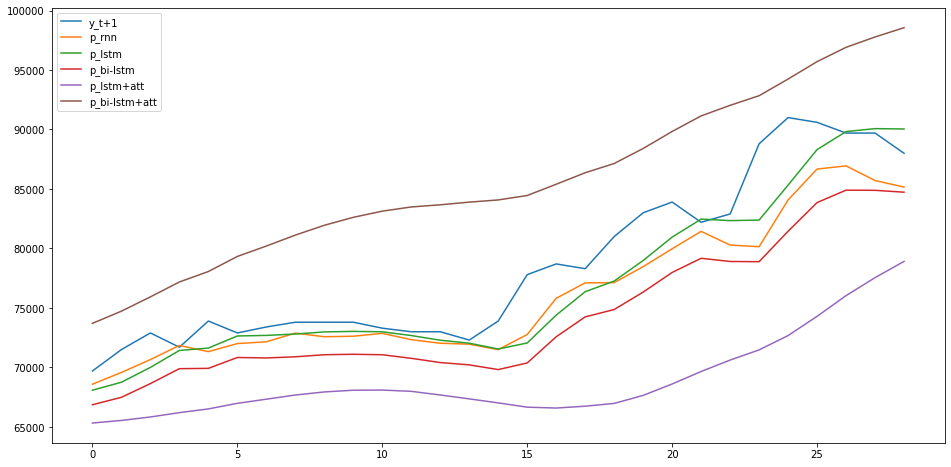

In [146]:
result.plot(figsize=(16,8))